In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.utils import shuffle
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

np.random.seed(42)

In [2]:
iris_data = load_iris() 
x = iris_data.data
y_ = iris_data.target.reshape(-1, 1)

encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y_)

#print(y)

# Split the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20)

/home/havish/.local/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [3]:
def relu(x):
    x[x<0]=0
    return x
def softmax(arr):
#     arr = arr/np.max(arr)
    return np.exp(arr)/(np.sum(np.exp(arr),axis=0))
def diff_relu(arr):
    z = np.zeros(arr.shape)
    z[arr<=0] = 0
    z[arr>0] = 1
    return z

In [4]:
def initializer(fan_out,fan_in):
    limit = np.sqrt(2*1.0/(fan_in+fan_out))
#     return np.random.uniform(-limit,limit,(fan_out,fan_in))
    return np.random.normal(0,limit,(fan_out,fan_in))

In [5]:
### architecture ###
in_dim = 4
hid1_dim = 10
hid2_dim = 10
out_dim = 3
W1 = initializer(hid1_dim,in_dim)
b1 = initializer(hid1_dim,1)
W2 = initializer(hid2_dim,hid1_dim)
b2 = initializer(hid2_dim,1)
W3 = initializer(out_dim,hid2_dim)
b3 = initializer(out_dim,1)

In [6]:
epochs = 500
num_samples = len(train_x)
batch_size = 10
delta_const = 1e-8
num_batches = num_samples/batch_size
eps = 1e-3
rho_1 = 0.7
t=1
rho_2 = 0.9
loss1 = []
r1 = {"W1" : np.zeros(W1.shape) , "W2" : np.zeros(W2.shape) ,"W3" : np.zeros(W3.shape),"b1": np.zeros(b1.shape)
     ,"b2" :np.zeros(b2.shape) , "b3" : np.zeros(b3.shape)}
r2 = {"W1" : np.zeros(W1.shape) , "W2" : np.zeros(W2.shape) ,"W3" : np.zeros(W3.shape),"b1": np.zeros(b1.shape)
     ,"b2" :np.zeros(b2.shape) , "b3" : np.zeros(b3.shape)}
for i in range(epochs):
    (x_train_subs,y_train_subs) = shuffle(train_x,train_y,random_state = 40)
    loss = 0
    for j in range(int(num_batches)):
        W1_upd = np.zeros((hid1_dim,in_dim))
        b1_upd = np.zeros((hid1_dim,1))
        W2_upd = np.zeros((hid2_dim,hid1_dim))
        b2_upd = np.zeros((hid2_dim,1))
        W3_upd = np.zeros((out_dim,hid2_dim))
        b3_upd = np.zeros((out_dim,1))
        for k in range(batch_size):
            z1 = relu(np.matmul(W1,x_train_subs[j*batch_size+k]).reshape(-1,1)+b1)
        
            z2 = relu(np.matmul(W2,z1).reshape(-1,1)+b2)

            out = softmax(np.matmul(W3,z2).reshape(-1,1) + b3)
        
            loss = loss + -np.log(out[np.argmax(y_train_subs[j*batch_size+k])])
        
            del_3 = out - y_train_subs[j*batch_size+k].reshape(-1,1)
            del_2 = np.matmul(W3.T,del_3)*diff_relu(z2)
            del_1 = np.matmul(W2.T,del_2)*diff_relu(z1)

            b3_upd += del_3
#         b3_upd = b3_upd.reshape(len(b3),1)
            b2_upd += del_2
#         b2_upd = b2_upd.reshape(len(b2),1)
            b1_upd += del_1
#         b1_upd = b1_upd.reshape(len(b1),1)
            W3_upd += np.matmul(del_3,z2.T)
            W2_upd += np.matmul(del_2,z1.T)
            W1_upd += np.matmul(del_1,x_train_subs[j*batch_size+k].reshape(-1,1).T)
        
        r1["W1"] = (rho_1)*r1["W1"] + (1-rho_1)*W1_upd
        r1["W2"] = (rho_1)*r1["W2"] + (1-rho_1)*W2_upd
        r1["W3"] = (rho_1)*r1["W3"] + (1-rho_1)*W3_upd
        r1["b1"] = (rho_1)*r1["b1"] + (1-rho_1)*b1_upd
        r1["b2"] = (rho_1)*r1["b2"] + (1-rho_1)*b2_upd
        r1["b3"] = (rho_1)*r1["b3"] + (1-rho_1)*b3_upd
        
        r1["W1"] = r1["W1"]/(1-(rho_1)**(t+1))
        r1["W2"] = r1["W2"]/(1-(rho_1)**(t+1))
        r1["W3"] = r1["W3"]/(1-(rho_1)**(t+1))
        r1["b1"] = r1["b1"]/(1-(rho_1)**(t+1))
        r1["b2"] = r1["b2"]/(1-(rho_1)**(t+1))
        r1["b3"] = r1["b3"]/(1-(rho_1)**(t+1))
        
        
        r2["W1"] = (rho_2)*r2["W1"] + (1-rho_2)*W1_upd*W1_upd
        r2["W2"] = (rho_2)*r2["W2"] + (1-rho_2)*W2_upd*W2_upd
        r2["W3"] = (rho_2)*r2["W3"] + (1-rho_2)*W3_upd*W3_upd
        r2["b1"] = (rho_2)*r2["b1"] + (1-rho_2)*b1_upd*b1_upd
        r2["b2"] = (rho_2)*r2["b2"] + (1-rho_2)*b2_upd*b2_upd
        r2["b3"] = (rho_2)*r2["b3"] + (1-rho_2)*b3_upd*b3_upd
        
        r2["W1"] = r2["W1"]/(1-(rho_2)**(t+1))
        r2["W2"] = r2["W2"]/(1-(rho_2)**(t+1))
        r2["W3"] = r2["W3"]/(1-(rho_2)**(t+1))
        r2["b1"] = r2["b1"]/(1-(rho_2)**(t+1))
        r2["b2"] = r2["b2"]/(1-(rho_2)**(t+1))
        r2["b3"] = r2["b3"]/(1-(rho_2)**(t+1))
        t = t+1
        
        
        
        W3 = W3 - (eps*r1["W3"])/np.sqrt(delta_const + r2["W3"])
        W2 = W2 - (eps*r1["W2"])/np.sqrt(delta_const + r2["W2"])
        W1 = W1 - (eps*r1["W1"])/np.sqrt(delta_const + r2["W1"])
        b3 = b3 - (eps*r1["b3"])/np.sqrt(delta_const + r2["b3"])
        b2 = b2 - (eps*r1["b2"])/np.sqrt(delta_const + r2["b2"])
        b1 = b1 - (eps*r1["b1"])/np.sqrt(delta_const + r2["b1"])
    loss1.append(loss)
    print("Epoch: " + str(i) + " Loss: " + str(loss))

Epoch: 0 Loss: [255.26937728]
Epoch: 1 Loss: [251.39774303]
Epoch: 2 Loss: [249.77485871]
Epoch: 3 Loss: [247.41999499]
Epoch: 4 Loss: [242.8480273]
Epoch: 5 Loss: [233.80911716]
Epoch: 6 Loss: [217.39008018]
Epoch: 7 Loss: [196.61713274]
Epoch: 8 Loss: [173.52667157]
Epoch: 9 Loss: [151.74173198]
Epoch: 10 Loss: [130.94070252]
Epoch: 11 Loss: [112.17851765]
Epoch: 12 Loss: [95.09389362]
Epoch: 13 Loss: [81.09658334]
Epoch: 14 Loss: [71.04130103]
Epoch: 15 Loss: [64.0643374]
Epoch: 16 Loss: [58.93028025]
Epoch: 17 Loss: [55.05095466]
Epoch: 18 Loss: [52.13222401]
Epoch: 19 Loss: [49.71648704]
Epoch: 20 Loss: [47.61215499]
Epoch: 21 Loss: [45.61933838]
Epoch: 22 Loss: [43.80851721]
Epoch: 23 Loss: [42.26481952]
Epoch: 24 Loss: [40.78296189]
Epoch: 25 Loss: [39.115736]
Epoch: 26 Loss: [37.56478123]
Epoch: 27 Loss: [36.19761]
Epoch: 28 Loss: [34.94455688]
Epoch: 29 Loss: [33.75372876]
Epoch: 30 Loss: [32.62417801]
Epoch: 31 Loss: [31.57242477]
Epoch: 32 Loss: [30.55136034]
Epoch: 33 Loss:

Epoch: 278 Loss: [7.24247377]
Epoch: 279 Loss: [7.24128746]
Epoch: 280 Loss: [7.2318284]
Epoch: 281 Loss: [7.23288363]
Epoch: 282 Loss: [7.22304158]
Epoch: 283 Loss: [7.22415724]
Epoch: 284 Loss: [7.21445652]
Epoch: 285 Loss: [7.2155159]
Epoch: 286 Loss: [7.20598344]
Epoch: 287 Loss: [7.20698527]
Epoch: 288 Loss: [7.19761428]
Epoch: 289 Loss: [7.19856556]
Epoch: 290 Loss: [7.18934731]
Epoch: 291 Loss: [7.19025492]
Epoch: 292 Loss: [7.18118144]
Epoch: 293 Loss: [7.18205167]
Epoch: 294 Loss: [7.17311515]
Epoch: 295 Loss: [7.17048633]
Epoch: 296 Loss: [7.16938312]
Epoch: 297 Loss: [7.16095423]
Epoch: 298 Loss: [7.16188527]
Epoch: 299 Loss: [7.15308971]
Epoch: 300 Loss: [7.15408782]
Epoch: 301 Loss: [7.14540024]
Epoch: 302 Loss: [7.14635977]
Epoch: 303 Loss: [7.13780446]
Epoch: 304 Loss: [7.13872528]
Epoch: 305 Loss: [7.13029631]
Epoch: 306 Loss: [7.13118612]
Epoch: 307 Loss: [7.12287533]
Epoch: 308 Loss: [7.12374002]
Epoch: 309 Loss: [7.11553938]
Epoch: 310 Loss: [7.11638475]
Epoch: 311 L

In [7]:
preds = []
true = []
# print(np.argmax(out))
for i in range(len(test_x)):
    z1 = relu(np.matmul(W1,test_x[i]).reshape(-1,1)+b1)
    z2 = relu(np.matmul(W2,z1).reshape(-1,1)+b2)
    out = softmax(np.matmul(W3,z2).reshape(-1,1) + b3)
    preds.append(np.argmax(out))
    true.append(np.argmax(test_y[i]))

In [8]:
print(preds)

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]


In [9]:
print(true)

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]


In [10]:
acc =accuracy_score(y_pred=preds,y_true=true)
print(acc)

1.0


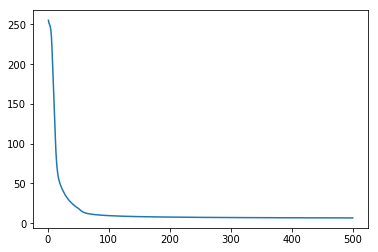

In [11]:
epochs = np.arange(1,501)
plt.plot(epochs,loss1)
plt.show()

In [12]:
for elem in np.array(loss1):
    print(str(elem[0])+',' , end = '')

255.2693772815275,251.39774303036808,249.77485871094632,247.4199949859063,242.84802729811554,233.80911715977933,217.3900801830696,196.6171327393254,173.52667157172118,151.7417319780494,130.94070252143874,112.17851765164089,95.09389362493492,81.09658334257901,71.04130103399002,64.06433739712307,58.930280247511696,55.0509546632815,52.132224009893875,49.71648704276075,47.61215498928812,45.61933838496957,43.80851720990527,42.26481951558981,40.78296188939124,39.115735998755646,37.5647812270534,36.197610004627506,34.94455687680153,33.75372876332871,32.62417801264,31.572424765492222,30.551360337364187,29.592700390905755,28.66853196570917,27.782936594811076,26.940648158940782,26.13199778450615,25.356357624170645,24.61350860169771,23.900766427381598,23.21668998734781,22.564279446832753,21.93743578106423,21.338518099523803,20.765983974468806,20.216645871524484,19.69237884308602,19.18788666825411,18.67146840122971,18.10693784510336,17.464543311521055,16.71257775587919,15.967903605913454,15.399627